In [2]:
# import the libraries
import cv2
import numpy as np
import pylab

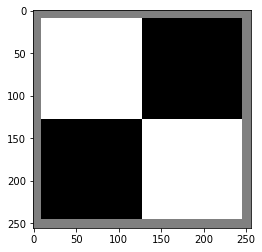

In [3]:
# load the image and convert it to grey
img = cv2.imread('ps1-input0.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pylab.imshow(gray,cmap=pylab.gray())
pylab.show()

Question 1.a
============
apply the canny edge filter on the image.
*note:* as this image don't have any noise, we don't need to add gaussian blur

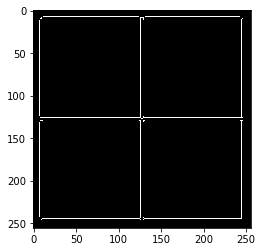

In [82]:
# apply canny edge detector
edges = cv2.Canny(gray,50,100,apertureSize = 7)
pylab.imshow(edges,cmap=pylab.gray())
pylab.show()

Question 2
==========
Write a Hough method for finding lines.

first we declare the discretization param called N (number of bins for each dimension of the accumulator).

note that as the picture has no noise at all, we can pick N = sqrt(256^2 + 256^2) wich gives us a 1px resolution.
Also, it could be relevant to have differents values of N for each dimension, as we are more likely sensitive to the errors on Thetha ( in comparison to d ). For the moment all the dimensions have the same discretization param.

In [83]:
# hough method parameters5
N = 360 # number of subdivision for theta and d

In [84]:
def get_H_pos(d, dmax, N):
    """
    get the correct bin for d
    return the column corresponding to d in H
    """
    return int((d + dmax) * N / (2 * dmax))


def get_vote(img, N=100, dmax=None):
    """
    compute the accumulator on the edges images
    """
    if dmax == None:
        dmax = np.math.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
    H = np.zeros((N + 1, N + 1))
    edge_points = np.argwhere(img > 1)
    for point in edge_points:
        for theta_bin in range(0, N):
            theta = theta_bin * np.math.pi / N
            d = point[0] * np.math.cos(theta) - point[1] * np.math.sin(theta)
            d_bin = get_H_pos(d, dmax, N)
            H[d_bin, theta_bin] = H[d_bin, theta_bin] + 1
    return H


as you can see there are 3 bright spots with the same theta=pi/2 there is also 3 bright sport with theta=pi (or 0)

now we are able to create the accumulator, we need to extract edges from it.
First let's define some utility functions:

In [85]:
def remove_feature(img, d_bin, theta_bin, dmax, N):
    """
    utility function that remove the pixel that lead to a given feature
    @param img: the image where you want to remove pixels
    @param d_bin theta_bin: the feature
    """
    (xmax,ymax) = img.shape
    for x in range(xmax):
        for y in range(ymax):
            theta = theta_bin*np.math.pi/N
            expected_d = x * np.math.cos(theta) - y * np.math.sin(theta)
            expected_d_bin = get_H_pos(expected_d, dmax, N)
            if expected_d_bin == d_bin:
                img[x,y] = 0 # remove the pixel
    return img

def convert_bins(d_bin, theta_bin, dmax, N):
    d = (d_bin*2*dmax/N)-dmax
    theta = theta_bin*np.math.pi/N
    return (d, theta)

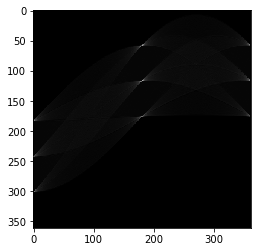

In [86]:
# apply hough algorithm
H = get_vote(edges, N)
# print hough transform
maximum = np.max(H)
hough_img = np.vectorize(lambda x: int(255*x/ maximum))(H)
pylab.imshow(hough_img, cmap=pylab.gray())
pylab.show()

In [87]:
# save picture
cv2.imwrite("ps1-2-1.jpg", hough_img)

True

In [88]:
def polar_features_extract(edges, N=100, minimum_votes=50):
    """
    return the list of polar coordinates corresponding to the lines extracted by hough filter
    @param edges: the image of the edges obtained by canny filter
    @param N: the resolution param ( number of bins ) * accuracy of lines localization *
    @param: minimum_votes: the minimal number of votes needed to be considered as feature * depth of the search *
    """
    # initialize algorithm
    remaining_edges = edges.copy()
    dmax = np.math.sqrt(edges.shape[0]**2+edges.shape[1]**2)
    H = get_vote(edges, N, dmax)
    maximum = np.max(H)
    bin_features = []
    features = []
    while maximum > minimum_votes:
        # add the maximum (ie. line) to the list of features
        new_features = np.argwhere(H==maximum)
        for (d_bin, theta_bin) in new_features:
            bin_features.insert(0, (d_bin, theta_bin))
            # remove the corresponding points from the original image
            (d, theta) = convert_bins(d_bin, theta_bin, dmax, N)
            remaining_edges = draw_feature(remaining_edges, d, theta, 0, 15) #remove_feature(remaining_edges, d_bin, theta_bin, dmax, N)
        # recompute accumulator and maxima
        H = get_vote(remaining_edges, N)
        maximum = np.max(H)
    for (d_bin, theta_bin) in bin_features:
        features.insert(0,convert_bins(d_bin, theta_bin, dmax, N))
    return features

In [13]:
def draw_feature(img, d, theta, color=(0,255,0), thickness=5):
    cross_points = []
    try:
        (xmax, ymax, _) = img.shape
    except :
        (xmax,ymax) = img.shape
    # compute coordinates of the line
    x_up = d / np.math.cos(theta)
    y_left = -d / np.math.sin(theta)
    x_down = (d + (ymax * np.math.sin(theta))) / np.math.cos(theta)
    y_right = (xmax * np.math.cos(theta) - d ) / np.math.sin(theta)
    if ((x_up >=0) and (x_up <= xmax)):
        cross_points.insert(0,(0,int(x_up)))
    if ((x_down >=0) and (x_down <= xmax)):
        cross_points.insert(0,(ymax,int(x_down)))
    if ((y_left >=0) and (y_left <= ymax)):
        cross_points.insert(0,(int(y_left),0))
    if ((y_right >=0) and (y_right <= ymax)):
        cross_points.insert(0,(int(y_right),xmax))
    # draw the line
    return cv2.line(img, cross_points[0], cross_points[1], color, thickness)

In [90]:
def full_hough(origin, edges, N=100, minimum_votes=50):
    polar_features = polar_features_extract(edges, N, minimum_votes)
    featured = origin.copy()
    for (d, theta) in polar_features:
        featured = draw_feature(featured, d, theta)
    return featured

/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


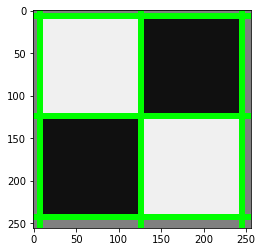

True

In [91]:
featured = full_hough(img, edges, N, 50)
pylab.imshow(featured,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-2-2.jpg", featured)

Question 3:
-------------

adding noise to the image

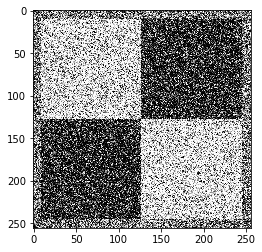

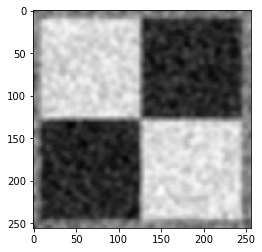

True

In [13]:
# load the image and convert it to grey
img_noise = cv2.imread('ps1-input0-noise.png')
gray_noise = cv2.cvtColor(img_noise, cv2.COLOR_BGR2GRAY)
gray_noise_smoothed = cv2.GaussianBlur( src=gray_noise, ksize=(11,11), sigmaX=3, sigmaY=3, borderType=cv2.BORDER_REFLECT)
pylab.imshow(gray_noise,cmap=pylab.gray())
pylab.show()
pylab.imshow(gray_noise_smoothed,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-3-a-1.jpg", gray_noise_smoothed)

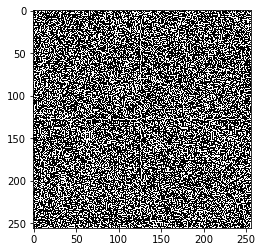

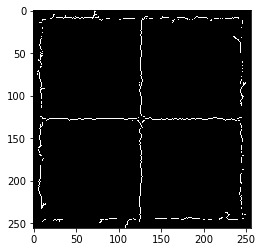

True

In [14]:
edges_noise = cv2.Canny(gray_noise,50,100,apertureSize = 3)
pylab.imshow(edges_noise,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-3-b-1.jpg", edges_noise)
edges_noise_smoothed = cv2.Canny(gray_noise_smoothed,50,100,apertureSize = 3)
pylab.imshow(edges_noise_smoothed,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-3-b-1.jpg", edges_noise_smoothed)

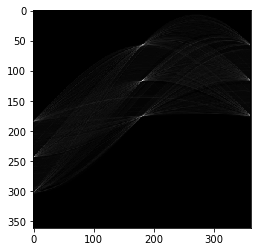

True

In [15]:
# apply hough algorithm
H = get_vote(edges_noise_smoothed, N)
# print hough transform
maximum = np.max(H)
hough_img_noise = np.vectorize(lambda x: int(255*x/ maximum))(H)
pylab.imshow(hough_img_noise, cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-3-c-1.jpg", hough_img_noise)

/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


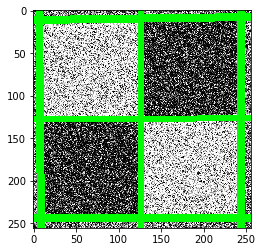

True

In [16]:
featured_noise = full_hough(img_noise, edges_noise_smoothed, N, 50)
pylab.imshow(featured_noise,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-3-c-2.jpg", featured_noise)

Question 4
==========

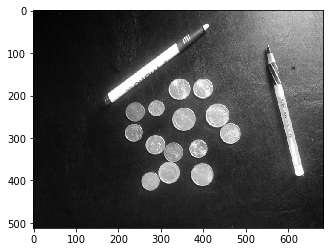

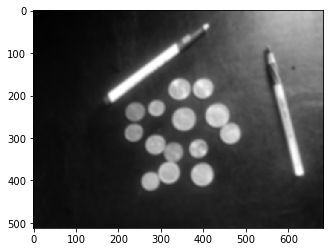

True

In [3]:
img_pen = cv2.imread('ps1-input1.jpg')
gray_pen = cv2.cvtColor(img_pen, cv2.COLOR_BGR2GRAY)
gray_pen_smoothed = cv2.GaussianBlur( src=gray_pen, ksize=(11,11), sigmaX=3, sigmaY=3, borderType=cv2.BORDER_REFLECT)
pylab.imshow(gray_pen,cmap=pylab.gray())
pylab.show()
pylab.imshow(gray_pen_smoothed,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-4-a-1.jpg", gray_pen_smoothed)

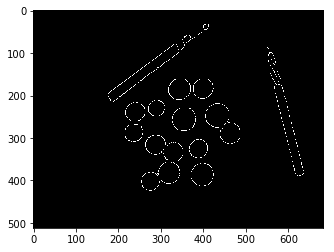

True

In [4]:
edges_pen_smoothed = cv2.Canny(gray_pen_smoothed,50,100,apertureSize = 3)
pylab.imshow(edges_pen_smoothed,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-4-b-1.jpg", edges_pen_smoothed)

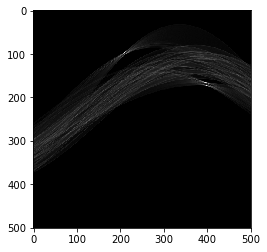

True

In [19]:
# apply hough algorithm
H = get_vote(edges_pen_smoothed, N=500)
# print hough transform
maximum = np.max(H)
hough_img_pen = np.vectorize(lambda x: int(255*x/ maximum))(H)
pylab.imshow(hough_img_pen, cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-4-c-1.jpg", hough_img_pen)

Hough parameters settings for this image:
-----------------------------------------
I started by setting the discretization param: I choosed N = 500 because it seemed to be a good compromise beetween precision and computation time.
I the had to choose the minimum of voters: I stated with a low value and increased it until i see only the lines corresponding to the pens

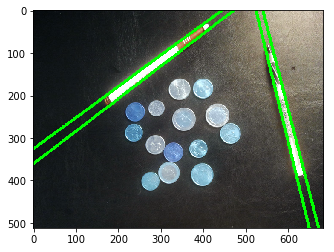

True

In [92]:
featured_noise = full_hough(img_pen, edges_pen_smoothed, 500, 200)
pylab.imshow(featured_noise,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-4-c-2.jpg", featured_noise)

Question 5
======
Hough detection of circles

In [38]:
def get_circle_vote(img, N=50, dmin=0, dmax=None):
    """
    compute the accumulator on the edges images
    """
    if dmax == None:
        dmax = min(img.shape[0], img.shape[1])
    H = np.zeros((N + 1, N + 1, (dmax-dmin)+1))
    edge_points = np.argwhere(img > 1)
    for point in edge_points:
        for xc_bin in range(0,N):
            for diam_bin in range(dmax-dmin):
                xc = (xc_bin*img.shape[0]/N)
                diam = diam_bin + dmin#(diam_bin*(dmax-dmin)/N)+dmin
                # todo: use (yc-point[0])**2 as bin to avoid heavy computation of sqrt
                if (diam**2 - (point[0]-xc)**2)>=0:
                    yc = point[1] - np.math.sqrt(diam**2 - (point[0]-xc)**2)
                    if yc >=0:
                        yc_bin = int(yc*N/img.shape[1])
                        H[xc_bin, yc_bin, diam_bin] = H[xc_bin, yc_bin, diam_bin] + 1
    return H


In [67]:
# apply hough algorithm to compute accumulator
N = 200
dmin = 22
dmax = 30
H = get_circle_vote(edges_pen_smoothed, N=N, dmin=dmin, dmax=dmax)

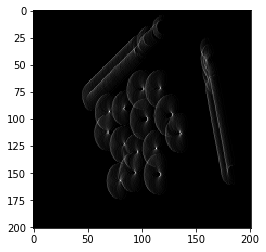

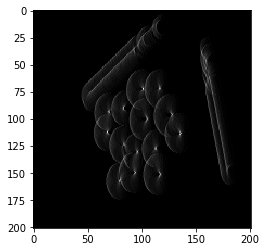

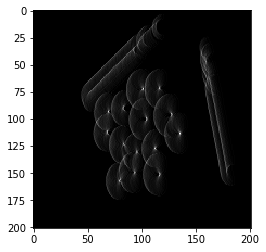

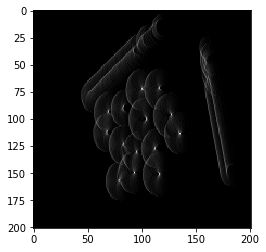

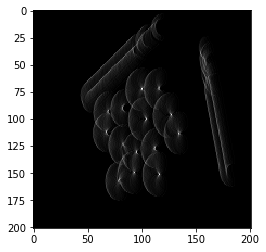

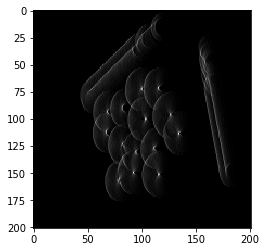

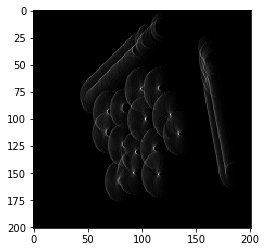

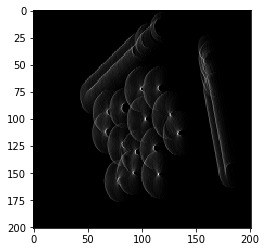

True

In [68]:
# print hough transform
maximum = np.max(H)
for i in range(dmax-dmin):
    hough_circle_img_pen = np.vectorize(lambda x: int(255*x/ maximum))(H[:,:,i])
    pylab.imshow(hough_circle_img_pen, cmap=pylab.gray())
    pylab.show()
cv2.imwrite("ps1-5-a-0.jpg", hough_circle_img_pen)

In [387]:
def circle_features_extract(edges, N=50, dmin=0, dmax=None, minimum_votes=50):
    """
    return the list of circles extracted by hough filter
    @param edges: the image of the edges obtained by canny filter
    @param N: the resolution param ( number of bins ) * accuracy of lines localization *
    @param: minimum_votes: the minimal number of votes needed to be considered as feature * depth of the search *
    """
    # initialize algorithm
    remaining_edges = edges.copy()
    H = get_circle_vote(edges, N, dmin, dmax)
    maximum = np.max(H)
    features = []
    while maximum > minimum_votes:
        # add the maximum (ie. line) to the list of features
        new_features = np.argwhere(H==maximum)
        for (x_bin, y_bin, d_bin) in new_features:
            # remove the corresponding points from the original image
            xc = int(x_bin*img_pen.shape[0]/N)
            yc = int(y_bin*img_pen.shape[1]/N)
            d = d_bin + dmin#int(d_bin*(dmax-dmin)/N + dmin)
            features.insert(0, (xc, yc, d))
            remaining_edges = cv2.circle(remaining_edges, (yc, xc), d, 0, d)#remove_feature(remaining_edges, d_bin, theta_bin, dmax, N)
        #pylab.imshow(remaining_edges, cmap=pylab.gray())
        #pylab.show()
        # recompute accumulator and maxima
        H = get_circle_vote(remaining_edges, N, dmin, dmax)
        maximum = np.max(H)
        #print((xc, yc, d))
    return features

def full_hough_circle(origin, edges, N, dmin, dmax, minimum_votes):
    circle_features = circle_features_extract(edges, N, dmin, dmax, minimum_votes)
    featured = origin.copy()
    for (xc, yc, d) in circle_features:
        featured = cv2.circle(featured, (yc, xc), d, (0,255,0), 5)
    return featured

In [65]:
hough_circle_pen = full_hough_circle(img_pen, edges_pen_smoothed, N=200, dmin=22, dmax=30, minimum_votes=40)

(386, 392, 28)
(256, 351, 28)
(381, 317, 25)
(289, 461, 24)
(238, 239, 22)
(181, 392, 27)
(325, 385, 22)
(314, 280, 27)
(243, 433, 24)
(335, 324, 26)
(227, 283, 23)
[(227, 283, 23), (335, 324, 26), (332, 327, 22), (332, 324, 25), (243, 433, 24), (314, 280, 27), (325, 385, 22), (286, 232, 23), (181, 392, 27), (238, 239, 22), (289, 461, 24), (381, 317, 25), (381, 314, 27), (184, 341, 26), (256, 351, 28), (386, 392, 28)]


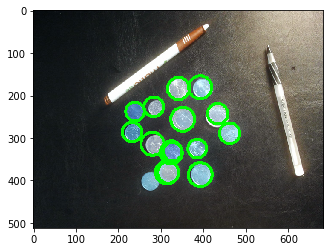

In [66]:
pylab.imshow(hough_circle_pen, cmap=pylab.gray())
pylab.show()


In [71]:
cv2.imwrite("ps1-5-a-1.jpg", hough_circle_pen)

True

Question 6
======

In [5]:
img_pen_2 = cv2.imread('ps1-input2.jpg')
gray_pen_2 = cv2.cvtColor(img_pen_2, cv2.COLOR_BGR2GRAY)
gray_pen_smoothed_2 = cv2.GaussianBlur( src=gray_pen_2, ksize=(31,31), sigmaX=5, sigmaY=5, borderType=cv2.BORDER_REFLECT)
pylab.imshow(gray_pen_2,cmap=pylab.gray())
pylab.show()
pylab.imshow(gray_pen_smoothed_2,cmap=pylab.gray())
pylab.show()

error: /feedstock_root/build_artefacts/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7456: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


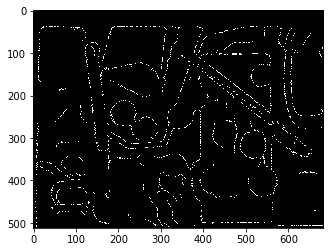

True

In [346]:
edges_pen_smoothed_2 = cv2.Canny(gray_pen_smoothed_2,10,50,apertureSize = 3)
pylab.imshow(edges_pen_smoothed_2,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-6-a-0.jpg", edges_pen_smoothed_2)

In [347]:
polar_features = polar_features_extract(edges_pen_smoothed_2, 250, 150)

/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/thibaut/usr/vendors/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


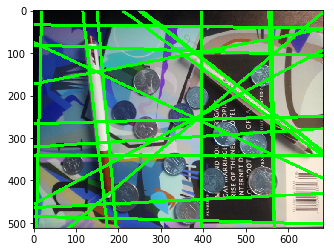

True

In [349]:
#featured_noise_2 = full_hough(img_pen_2, edges_pen_smoothed_2, 500, 150)
featured = img_pen_2.copy()
for (d, theta) in polar_features:
    featured = draw_feature(featured, d, theta)
pylab.imshow(featured,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-6-a.jpg", featured_noise_2)

Question 6 b
--------------

These problems comes from the fact that (most of the time) the edges caused by depth discontinuty are less saillient that edges caused by color change. Without a différent way to aquire images, it will be very hard to solve.

Question 6 c
=======

In [350]:
def filter_parallel(polar_features, max_angle, max_dist):
    kept_features = []
    for i in range(len(polar_features)-1):
        (d_bin,t_bin) = polar_features[i]
        for j in range(i+1,len(polar_features)):
            (d2_bin,t2_bin) = polar_features[j]
            if (abs(t2_bin-t_bin)<=max_angle) and (abs(d2_bin-d_bin)<max_dist) and (abs(d2_bin-d_bin)>(max_dist*0.5)):
                kept_features.append(polar_features[i])
                kept_features.append(polar_features[j])
    return kept_features

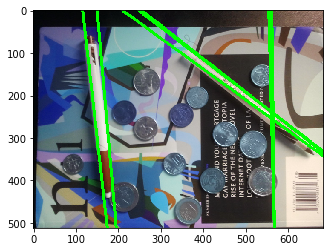

True

In [352]:
features = filter_parallel(polar_features, 1, 9)
featured = img_pen_2.copy()
for (d, theta) in features:
    featured = draw_feature(featured, d, theta)
pylab.imshow(featured,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-6-b.jpg", featured)


Question 7
------------

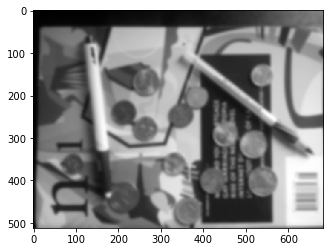

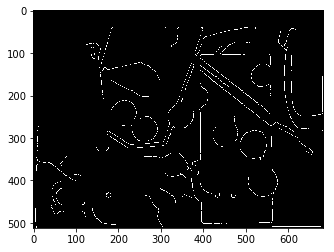

True

In [379]:
gray_pen_smoothed_3 = cv2.GaussianBlur( src=gray_pen_2, ksize=(31,31), sigmaX=3, sigmaY=3, borderType=cv2.BORDER_REFLECT)
pylab.imshow(gray_pen_smoothed_3,cmap=pylab.gray())
pylab.show()
edges_pen_smoothed_3 = cv2.Canny(gray_pen_smoothed_3,75,120,apertureSize = 3)
pylab.imshow(edges_pen_smoothed_3,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-7-a-1.jpg", gray_pen_smoothed_3)

In [394]:
hough_circle_pen_2 = full_hough_circle(img_pen_2, edges_pen_smoothed_2, N=200, dmin=22, dmax=35, minimum_votes=40)

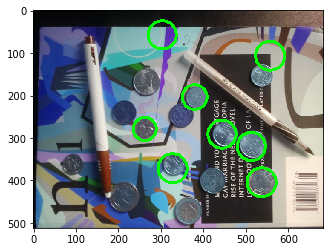

True

In [395]:
pylab.imshow(hough_circle_pen_2,cmap=pylab.gray())
pylab.show()
cv2.imwrite("ps1-7-a-2.jpg", hough_circle_pen_2)

Question 7 b
--------------

by looking at the canny image, it seems very difficult to detect all the circles without having false alarms. Some coins don't even appears on the canny image and some printed shapes may lead to false positive. In order to avoid these false positives, I've restricted the radius, from 22 pixels to 35 pixels. Using the gradient would also be a great idea to avoid false positive.

Question 8 a
------------

Question 8 b
--------------
to do this we can modelize the ellipse: to do this we need 5 params:
- xc and yc: the coordinates of the centers
- ax1 and ax2: the length of the 2 axis
- theta: the orientation of the ellipse

infortunately this means that the algorithm would have a complexity in O(n^4). In order to gain as much time as we have to reduce the range of the parameters:

for instance we already knows that the ratio ax1/ax2 should be in [0.8, 1.2] and also theta should be in [-30°, +30°]

in the following attempt the idea is to get only the coordinates of the center: by voting for a line in the direction of the gradient, all vote should concentrate around a point for a circle or around a cross for an ellipse. by this way we should get something computationally reasonable.

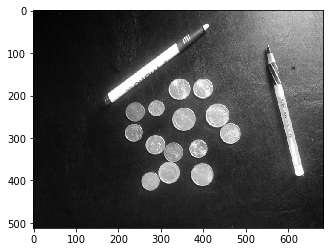

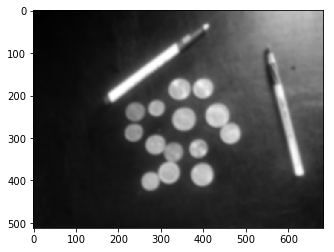

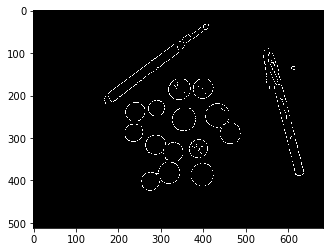

In [58]:
img_pen_2 = cv2.imread('ps1-input1.jpg')
gray_pen_2 = cv2.cvtColor(img_pen_2, cv2.COLOR_BGR2GRAY)
gray_pen_smoothed_2 = cv2.GaussianBlur( src=gray_pen_2, ksize=(31,31), sigmaX=3, sigmaY=3, borderType=cv2.BORDER_REFLECT)
pylab.imshow(gray_pen_2,cmap=pylab.gray())
pylab.show()
pylab.imshow(gray_pen_smoothed_2,cmap=pylab.gray())
pylab.show()
edges_pen_smoothed_2 = cv2.Canny(gray_pen_smoothed_2,10,50,apertureSize = 3)
pylab.imshow(edges_pen_smoothed_2,cmap=pylab.gray())
pylab.show()

In [63]:
def compute_gradients_direction(src):
    img = src.copy()
    img = cv2.GaussianBlur( src=img, ksize=(27,27), sigmaX=15, sigmaY=15, borderType=cv2.BORDER_REFLECT)
    img_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    img_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    res = np.arctan2(img_y, img_x)
    vfunc = np.vectorize(lambda t: t ** 2)
    res2 = np.vectorize(np.math.sqrt)(
        np.add(
            vfunc(img_x),
            vfunc(img_y)
        )
    )
    return (res,res2)
    #return cv2.GaussianBlur( src=res, ksize=(27,27), sigmaX=15, sigmaY=15, borderType=cv2.BORDER_REFLECT)


In [64]:
def get_ellipse_vote(img, edges, N, dmin, dmax):
    """
    compute the accumulator on the edges images
    """
    # first compute the gradients directions for the image
    (grad_orient, grad_mag) = compute_gradients_direction(img)
    H = np.zeros((N+1, N+1, dmax-dmin))
    edge_points = np.argwhere(edges > 1)
    for point in edge_points:
        for rho in range(dmin,dmax,1):
            grad = grad_orient[point[0], point[1]]
            a = np.cos(grad)
            b = np.sin(grad)
            x1 = int(point[0] + rho*(b))
            y1 = int(point[1] + rho*(a))
            x1_bin = int(x1*N/img.shape[0])
            y1_bin = int(y1*N/img.shape[1])
            rho_bin = int(rho-dmin)
            H[x1_bin,y1_bin,rho_bin] = H[x1_bin,y1_bin,rho_bin] + grad_mag[point[0], point[1]]
    return H


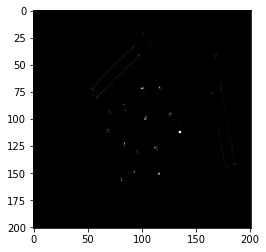

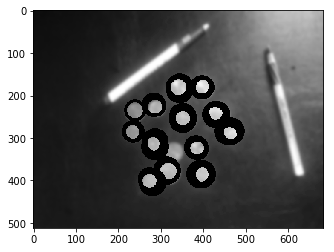

In [69]:
N = 200
dmin = 20
dmax = 30
H = get_ellipse_vote(gray_pen_smoothed_2, edges_pen_smoothed_2, N, dmin, dmax)
cv2.GaussianBlur(src=H, ksize=(27, 27), sigmaX=10, sigmaY=10, borderType=cv2.BORDER_REFLECT)
maximum = np.max(H)
hough_img_pen = np.vectorize(lambda x: int(255 * x / maximum))(H[:, :, 5])
pylab.imshow(hough_img_pen, cmap=pylab.gray())
pylab.show()
features = np.argwhere(H >= 0.22 * maximum)
result = gray_pen_smoothed_2.copy()
for feature in features:
    cv2.circle(result, (feature[1] * result.shape[1] / N, feature[0] * result.shape[0] / N), feature[2] + dmin, 0,
               thickness=5)
pylab.imshow(result, cmap=pylab.gray())
pylab.show()
